<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/4.%20Transfer%20Learning/Transfer_Learning_predict_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip

--2020-04-15 03:02:26--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229734282 (219M) [application/zip]
Saving to: ‘flower-photos.zip’

flower-photos.zip   100%[===================>] 219.09M  44.8MB/s    in 5.4s    

2020-04-15 03:02:32 (40.9 MB/s) - ‘flower-photos.zip’ saved [229734282/229734282]



In [0]:
!unzip flower-photos.zip

# Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

In [0]:
import os
import torch
import numpy as np

import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_on_gpu = torch.cuda.is_available()

# Load and Transform Data
We'll be using PyTorch's ImageFolder class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:

root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
Where, in this case, the root folder for training is flower_photos/train/ and the classes are the names of flower types.

In [0]:
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Transforming Data
When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects 224-dim square images as input and so, we resize each flower image to fit this mold.

In [10]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(244),
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print(len(train_data))
print(len(test_data))

3130
540


# DataLoaders and Data Visualization

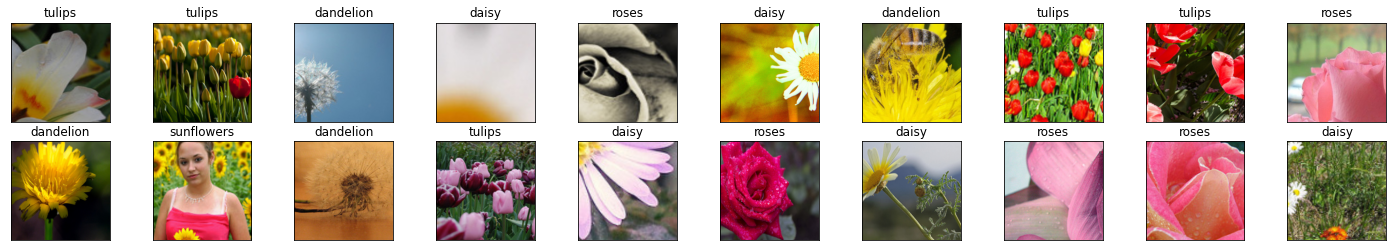

In [29]:

# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, num_workers=num_workers, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Define the Model
To define a model for training we'll follow these steps:

1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will not change during training.**

In [12]:
vgg16 = models.vgg16(pretrained=True)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

# Final Classifier Layer
Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.

>
>This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. vgg16.classifier[6] is the sixth layer in a group of layers named "classifier". 

In [0]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [14]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer

if train_on_gpu:
  vgg16.cuda()


print(vgg16.classifier[6].out_features)

5


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

# Training the model

In [18]:
n_epochs=2

for epoch in range(1, n_epochs+1):
  training_loss = 0.0

  for batch_i, (data, target) in enumerate(train_loader):
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()
    output = vgg16(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()  
    
    training_loss = loss.item()
    if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, training_loss / 20))
            training_loss = 0.0

Epoch 1, Batch 20 loss: 0.0640206396579742
Epoch 1, Batch 40 loss: 0.0608663618564606
Epoch 1, Batch 60 loss: 0.0608464598655701
Epoch 1, Batch 80 loss: 0.0445496141910553
Epoch 1, Batch 100 loss: 0.0432683706283569
Epoch 1, Batch 120 loss: 0.0569792091846466
Epoch 1, Batch 140 loss: 0.0479272753000259
Epoch 2, Batch 20 loss: 0.0443296760320663
Epoch 2, Batch 40 loss: 0.0445818126201630
Epoch 2, Batch 60 loss: 0.0413727134466171
Epoch 2, Batch 80 loss: 0.0433003485202789
Epoch 2, Batch 100 loss: 0.0346069961786270
Epoch 2, Batch 120 loss: 0.0356654971837997
Epoch 2, Batch 140 loss: 0.0328846901655197


# Testing the model

In [20]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()

for data, target in test_loader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  
  output = vgg16(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label]+=1
  
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.040031

Test Accuracy of daisy: 42% ( 3/ 7)
Test Accuracy of dandelion: 100% ( 2/ 2)
Test Accuracy of roses: 66% ( 2/ 3)
Test Accuracy of sunflowers:  0% ( 0/ 4)
Test Accuracy of tulips: 75% ( 3/ 4)
Test Loss: 0.030743

Test Accuracy of daisy: 44% ( 4/ 9)
Test Accuracy of dandelion: 85% ( 6/ 7)
Test Accuracy of roses: 83% ( 5/ 6)
Test Accuracy of sunflowers: 40% ( 4/10)
Test Accuracy of tulips: 62% ( 5/ 8)
Test Loss: 0.020692

Test Accuracy of daisy: 62% (10/16)
Test Accuracy of dandelion: 90% (10/11)
Test Accuracy of roses: 80% ( 8/10)
Test Accuracy of sunflowers: 53% ( 7/13)
Test Accuracy of tulips: 70% ( 7/10)
Test Loss: 0.017479

Test Accuracy of daisy: 75% (18/24)
Test Accuracy of dandelion: 86% (13/15)
Test Accuracy of roses: 83% (10/12)
Test Accuracy of sunflowers: 57% ( 8/14)
Test Accuracy of tulips: 73% (11/15)
Test Loss: 0.029236

Test Accuracy of daisy: 76% (19/25)
Test Accuracy of dandelion: 89% (17/19)
Test Accuracy of roses: 77% (14/18)
Test Accuracy of sunfl